In [3]:
%matplotlib inline
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import collections
import math

In [4]:
G=nx.read_weighted_edgelist("4932.protein.links.v11.0.txt",comments="#",nodetype=str)
# delete those edges with a combined score of <= thershold_score (small confidence)
threshold_score = 700
for edge in G.edges: 
    G.get_edge_data(edge[0],edge[1])
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])
largest_cc = max(nx.connected_components(G),key=len)
G=G.subgraph(largest_cc)

## Question 1

In [5]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,density=True)
  plt.xscale('log')
  plt.xlabel('Degree k')
  plt.yscale('log')
  plt.ylabel('Fraction p_k of vertices having degree k')
  plt.show()

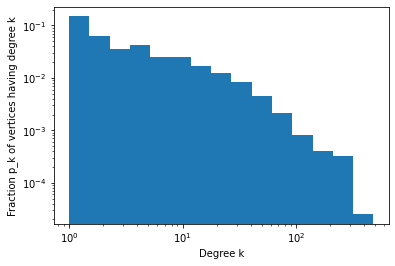

In [6]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plot_loghist(degree_sequence,15)

## Question 2

In [7]:
def overlay(x,bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,density=True)

  x = np.linspace(min(degree_sequence),max(degree_sequence), 10000)
  a = 1
  y = x**(-a)
  plt.plot(x,y)
  a = 2
  y = x**(-a)
  plt.plot(x,y)
  a = 3
  y = x**(-a)
  plt.plot(x,y)
  plt.xscale('log')
  plt.xlabel('Degree k')
  plt.yscale('log')
  plt.ylabel('Fraction p_k of vertices having degree k')
  plt.show()

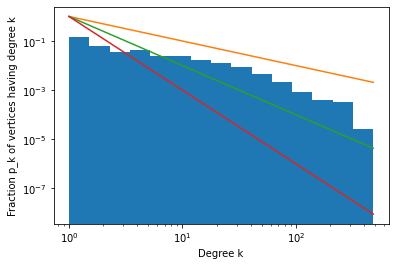

In [8]:
overlay(degree_sequence,15)

## Question 3 

In [9]:
def cumulative(degree_sequence):
    x = []
    y = []
    # as in Newman's method 
    for i in range(0,len(degree_sequence)):
        x.append(degree_sequence[i])
        y.append((i+1)/len(degree_sequence))      
    plt.plot(x,y)
    plt.xscale('log')
    plt.xlabel('Degree k')
    plt.yscale('log')
    plt.ylabel('cumulative distribution function')
    plt.show()

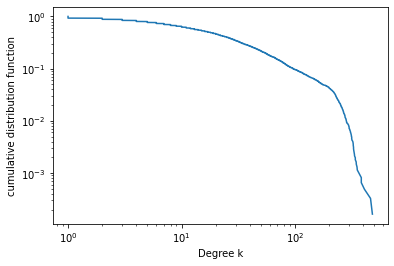

In [10]:
cumulative(degree_sequence)

## Question 4

In [11]:
def overlay_cumulative(degree_sequence):
    x = []
    y = []
    # as in Newman's method 
    for i in range(0,len(degree_sequence)):
        x.append(degree_sequence[i])
        y.append((i+1)/len(degree_sequence))      
    plt.plot(x,y)

    x = np.linspace(min(degree_sequence),max(degree_sequence), 10000)
    a = 1
    y = x**(-(a-1))
    plt.plot(x,y)
    a = 2
    y = x**(-(a-1))
    plt.plot(x,y)
    a = 3
    y = x**(-(a-1))
    plt.plot(x,y)
    plt.xscale('log')
    plt.xlabel('Degree k')
    plt.yscale('log')
    plt.ylabel('cumulative distribution function')
    plt.show()

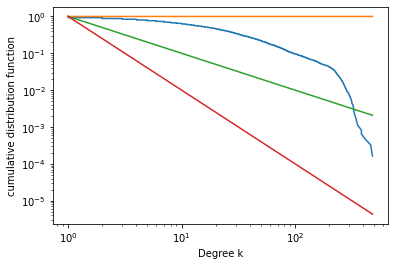

In [12]:
overlay_cumulative(degree_sequence)

## Question 5 

Here we try to use formula (8.6) from the Newman's book. I also followed Newman's suggested reading on methods to determine k_min. (http://tuvalu.santafe.edu/~aaronc/courses/5352/readings/Clauset_Shalizi_Newman_09_PowerlawDistributionsInEmpiricalData.pdf), starting from page 669 

In [13]:
def find_alpha(degree_sequence,k_min):
    summation = sum([math.log((k)/(k_min-0.5)) for k in degree_sequence if k >= k_min])
    a = 1 + sum([1 for k in degree_sequence if k >= k_min])*summation**(-1)
    error = (a-1)/math.sqrt(sum([1 for k in degree_sequence if k >= k_min]))
    # print("alpha = {:.3f} +- {:.3f}".format(a,error))
    return a 

There are two eye-ball methods the authors suggested:

1.estimate visually the point beyond which the PDF or CDF of the distribution becomes roughly straight on a log-log plot 
2. plot α (or a related quantity) as a function of k_min and identify a point beyond which the value appears relatively stable 

It's hard to estimate using the first method. I implmented the second method below, however alpha doesn't actually stabilise. 

The author also suggested two more objective methods to decide k_min propsed by Handcock and Jones and by Clauset et al. However, i don't have to time to look at them in detail, and i think they require more statistical knowledege than i currently have. 
 

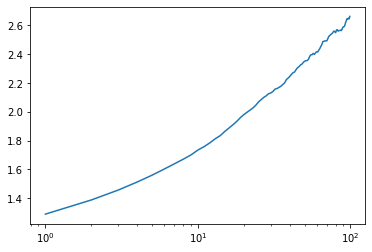

In [14]:
x=[]
y=[]
for k_min in range(1,100):
    x.append(k_min)
    y.append(find_alpha(degree_sequence,k_min)) 
plt.plot(x,y)
plt.xscale('log')
plt.show()

So we have to fall back to fitting line with different values of alpha to the histogram/CDF. 

In [15]:
def overlay_fit(x,bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,density=True)
  x = np.linspace(min(degree_sequence),max(degree_sequence), 10000)
  a = 1.6
  y = x**(-a)
  plt.plot(x,y)
  plt.xscale('log')
  plt.xlabel('Degree k')
  plt.yscale('log')
  plt.ylabel('Fraction p_k of vertices having degree k')
  plt.show()

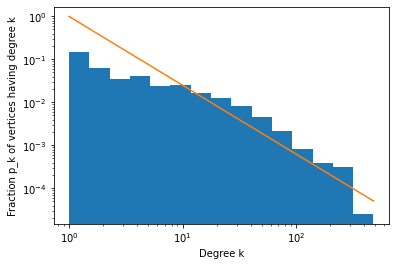

In [16]:
overlay_fit(degree_sequence,15)

In [17]:
def overlay_cumulative_fit(degree_sequence):
    x = []
    y = []
    # as in Newman's method 
    for i in range(0,len(degree_sequence)):
        x.append(degree_sequence[i])
        y.append((i+1)/len(degree_sequence))      
    plt.plot(x,y)
    x = np.linspace(min(degree_sequence),max(degree_sequence), 10000)
    a = 1.6
    y = x**(-(a-1))
    plt.plot(x,y)
    plt.xscale('log')
    plt.xlabel('Degree k')
    plt.yscale('log')
    plt.ylabel('cumulative distribution function')
    plt.show()

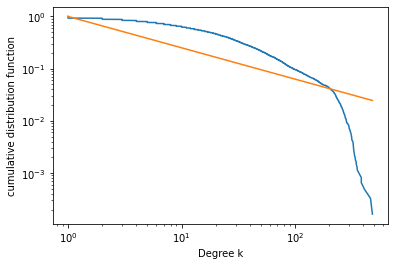

In [18]:
overlay_cumulative_fit(degree_sequence)

We find lines with alpha value = 1.6, fits very nicely with the the slope histogram/CDF. However, we can't say this confidently. To produce more accurate estimation of alpha, we have to use more robust methods, such as the ones in (http://tuvalu.santafe.edu/~aaronc/courses/5352/readings/Clauset_Shalizi_Newman_09_PowerlawDistributionsInEmpiricalData.pdf)

In [19]:
find_alpha(degree_sequence,6)

1.6021683508715792

Interesting result: The alpha value 1.6 coincide with find_alpha(degree_sequence,6), where k_min is set to 6.